# Main imports and code

In [1]:
# check which gpu we're using
!nvidia-smi

Sat Mar  1 16:41:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install simpletransformers
!pip install tensorboardx
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.9 MB/s eta 0:00:00
  Crea

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
from transformers import pipeline

In [4]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [5]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Fetch Don't Patronize Me! data manager module

In [6]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [7]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [8]:
from dont_patronize_me import DontPatronizeMe

In [9]:
dpm = DontPatronizeMe('.', '.')

In [14]:
# Import the files below (can be found in spec github)
# Should remove this step in final so can be run end to end w/o invervention

from google.colab import files
uploaded = files.upload()

'''
train_semeval_parids-labels.csv
dev_semeval_parids-labels.csv
dontpatronizeme_pcl.tsv
dontpatronizeme_unlabeled_pcl.tv
'''

Saving train_semeval_parids-labels.csv to train_semeval_parids-labels.csv


'\ntrain_semeval_parids-labels.csv\ndev_semeval_parids-labels.csv\ndontpatronizeme_pcl.tsv\ndontpatronizeme_unlabeled_pcl.tv\n'

In [15]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load paragraph IDs

In [16]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [17]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [18]:
data=dpm.train_task1_df

In [ ]:
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4




# Rebuild training set (Task 1)

In [19]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [21]:
import random

In [20]:
trdf1 = pd.DataFrame(rows)
og_trdf1 = trdf1.copy()

In [ ]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


Class 1: 794 Class 0: 7581


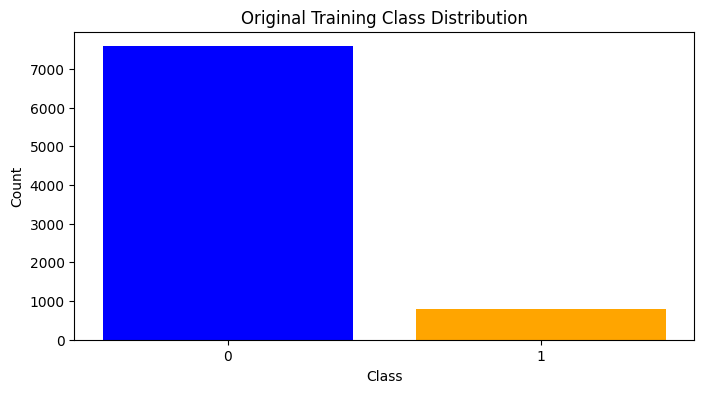

In [ ]:
import matplotlib.pyplot as plt

minority_count = trdf1[trdf1.label == 1].shape[0]
majority_count = trdf1[trdf1.label == 0].shape[0]
print("Class 1:", minority_count, "Class 0:", majority_count)

# Training set distribution (before oversampling)
plt.figure(figsize=(8, 4))
train_counts = trdf1['label'].value_counts().sort_index()
plt.bar(train_counts.index.astype(str), train_counts.values, color=['blue', 'orange'])
plt.title("Original Training Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from transformers import pipeline

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

# Replace up to 5 words and return 1 new text item
def synonym_replacement(text, num_replacements):

    # Tokenize
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Find candidate words (adjectives and adverbs)
    candidates = [word for word, tag in pos_tags if tag in ["JJ", "RB"]]
    random.shuffle(candidates)

    # Get some candidate words for replacement
    selected_words = candidates[:num_replacements]
    replacements = {}

    # Try to replace each word
    for word_to_replace in selected_words:
        masked_sentence = text.replace(word_to_replace, "[MASK]", 1)

        try:
            predictions = fill_mask(masked_sentence)
            synonyms = [pred["token_str"] for pred in predictions[:5]]

            if synonyms:
                replacements[word_to_replace] = random.choice(synonyms)
        except:
            continue

    for old_word, new_word in replacements.items():
        text = text.replace(old_word, new_word, 1)

    return text




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Initialise two translation pipelines.

# For English to French translation:
en_to_fr = pipeline("translation_en_to_fr", model="Helsinki-NLP/opus-mt-en-fr")
# For French to English translation:
fr_to_en = pipeline("translation_fr_to_en", model="Helsinki-NLP/opus-mt-fr-en")

def backtranslate(text):
    """
    Perform backtranslation: English → French → English.
    """
    try:
      # Translate from English to French
      fr_text = en_to_fr(text)[0]['translation_text']
      # Translate back from French to English
      en_text = fr_to_en(fr_text)[0]['translation_text']
    except Exception as e:
      return text
    return en_text

# Example: Backtranslate a single sentence
example_text = "I am listening to some good music right now."
print("Original:", example_text)
print("Backtranslated:", backtranslate(example_text))

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Device set to use cpu


Original: I am listening to some good music right now.
Backtranslated: I'm listening to good music right now.


In [ ]:
# Initialise augmented data as empty
augmented_data = []

# Get most recent par_id and add one for new text to use
curr_par_id = int(trdf1['par_id'].iloc[-1]) + 1

# For each paragraph in the training data
for _, row in trdf1.iterrows():

    if row["label"] == 1:
        for x in range(3):
            
            # Generate 5 augmented (synonym replaced) new paragraphs
            augmented_text = synonym_replacement(row["text"], 5)
            
            augmented_data.append({"par_id": str(curr_par_id),
                                    "community": row["community"],
                                    "text": augmented_text,
                                    "label": row["label"]})
            curr_par_id += 1

print("Synonym replaced samples:", len(augmented_data))
# Convert to DataFrame
augmented_trdf1 = pd.DataFrame(augmented_data)
trdf1 = pd.concat([trdf1, augmented_trdf1]).drop_duplicates().reset_index(drop=True)
print("After oversampling - New class distribution:", trdf1['label'].value_counts().to_dict())

# Plot the training class distribution after oversampling
plt.figure(figsize=(8, 4))
train_counts_after = trdf1['label'].value_counts().sort_index()
plt.bar(train_counts_after.index.astype(str), train_counts_after.values, color=['blue', 'orange'])
plt.title("Training Class Distribution (After Oversampling)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
trdf1

In [ ]:
# Create augmented examples via backtranslation.
augmented_data_bt = []
curr_par_id = int(trdf1['par_id'].iloc[-1]) + 1
for idx, row in trdf1.iterrows():
    bt_text = backtranslate(row["text"])
    augmented_data_bt.append({
        "par_id": str(curr_par_id),
        "community": row["community"],
        "text": bt_text,
        "label": row["label"]
    })
    curr_par_id += 1

augmented_trdf1_bt = pd.DataFrame(augmented_data_bt)
print("Backtranslated samples:", len(augmented_trdf1_bt))

# Combine original and augmented datasets
trdf1 = pd.concat([trdf1, augmented_trdf1_bt]).drop_duplicates().reset_index(drop=True)

In [ ]:
# Save augmented dataset
trdf1.to_csv("augmented_pcl_dataset.csv", index=False)

In [ ]:
trdf1

Class 1: 4545 Class 0: 43119


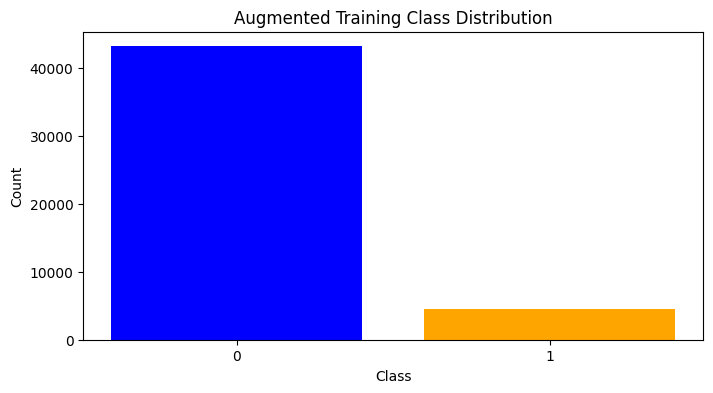

In [22]:
import matplotlib.pyplot as plt

# Once we have run the above once we can just load from the file
trdf1 = pd.read_csv('augmented_pcl_dataset.csv')

minority_count = trdf1[trdf1.label == 1].shape[0]
majority_count = trdf1[trdf1.label == 0].shape[0]
print("Class 1:", minority_count, "Class 0:", majority_count)

# Training set distribution
plt.figure(figsize=(8, 4))
train_counts = trdf1['label'].value_counts().sort_index()
plt.bar(train_counts.index.astype(str), train_counts.values, color=['blue', 'orange'])
plt.title("Augmented Training Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
47659,16755,refugee,Rescue teams search for survivors on the rubbl...,0
47660,16756,hopeless,The launch of ' Happy Birthday ' took place la...,0
47661,16757,homeless,"The unrest has left at least 20,000 people dea...",0
47662,16758,hopeless,You have to see it from my perspective . I may...,0


# Rebuild test set (Task 1)

In [23]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [24]:
len(rows)

2094

In [25]:
tedf1 = pd.DataFrame(rows)

In [26]:
tedf1 = tedf1.sample(frac=1, random_state=42).reset_index(drop=True)

# RoBERTa Baseline for Task 1

In [27]:
training_set1 = trdf1

In [ ]:
training_set1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
47659,16755,refugee,Rescue teams search for survivors on the rubbl...,0
47660,16756,hopeless,The launch of ' Happy Birthday ' took place la...,0
47661,16757,homeless,"The unrest has left at least 20,000 people dea...",0
47662,16758,hopeless,You have to see it from my perspective . I may...,0


# Bag-of-Words (BOW) Model Baseline

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import pandas as pd

In [29]:
# downsample negative instances
pcldf = og_trdf1[og_trdf1.label==1]
npos = len(pcldf)

baseline_training_set1 = pd.concat([pcldf,og_trdf1[og_trdf1.label==0][:npos*2]])

In [30]:
# Create a BoW representation using CountVectorizer.
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(baseline_training_set1['text'])
y_train = baseline_training_set1['label']

# Transform the test set.
X_test_bow = bow_vectorizer.transform(tedf1['text'])

# Train a logistic regression classifier.
bow_clf = LogisticRegression(max_iter=1000, random_state=42)
print("Training BoW baseline model...")
bow_clf.fit(X_train_bow, y_train)

# Make predictions on the test set.
bow_preds = bow_clf.predict(X_test_bow)

# Evaluate performance.
bow_f1 = f1_score(tedf1['label'], bow_preds)
print("BoW Baseline F1 Score:", bow_f1)
print("Classification Report (BoW):")
print(classification_report(tedf1['label'], bow_preds))

Training BoW baseline model...
BoW Baseline F1 Score: 0.3368421052631579
Classification Report (BoW):
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      1895
           1       0.26      0.48      0.34       199

    accuracy                           0.82      2094
   macro avg       0.60      0.67      0.62      2094
weighted avg       0.88      0.82      0.84      2094



# TF-IDF Model Baseline

In [31]:
# Create a TF-IDF representation using TfidfVectorizer.
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(baseline_training_set1['text'])

# Transform the test set.
X_test_tfidf = tfidf_vectorizer.transform(tedf1['text'])

# Train a logistic regression classifier.
tfidf_clf = LogisticRegression(max_iter=1000, random_state=42)
print("Training TF-IDF baseline model...")
tfidf_clf.fit(X_train_tfidf, y_train)

# Make predictions on the test set.
tfidf_preds = tfidf_clf.predict(X_test_tfidf)

# Evaluate performance.
tfidf_f1 = f1_score(tedf1['label'], tfidf_preds)
print("TF-IDF Baseline F1 Score:", tfidf_f1)
print("Classification Report (TF-IDF):")
print(classification_report(tedf1['label'], tfidf_preds))

Training TF-IDF baseline model...
TF-IDF Baseline F1 Score: 0.35359116022099446
Classification Report (TF-IDF):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1895
           1       0.39      0.32      0.35       199

    accuracy                           0.89      2094
   macro avg       0.66      0.63      0.65      2094
weighted avg       0.88      0.89      0.88      2094



# Sample Weights vs Class Weights
Sample weights better for extremely unbalanced datasets.


In [32]:
from sklearn.metrics import f1_score
import torch.nn.functional as F
import random
import numpy as np

In [33]:
# Pre-compute sample weights based on training_set1 class frequencies.
# This gives a higher weight to Class 1 (the minority).
class_counts = training_set1['label'].value_counts().to_dict()
sample_weights = training_set1['label'].apply(lambda x: 1.0 / class_counts[x]).values
print(f"Sample Weight for Class 0: {1.0 / class_counts[0]:.7f}")
print(f"Sample Weight for Class 1: {1.0 / class_counts[1]:.7f}")

Sample Weight for Class 0: 0.0000232
Sample Weight for Class 1: 0.0002200


In [ ]:
# Alternatively we can compute class weights
# Total number of samples and number of classes.
N = len(training_set1)
C = len(class_counts)

# Compute class weights.
class_weights_dict = {cls: N / (C * count) for cls, count in class_counts.items()}
print("Class Weights:", {k: round(v, 7) for k, v in class_weights_dict.items()})

# Convert to a PyTorch tensor (ordered by class index).
sorted_classes = sorted(class_weights_dict.keys())
class_weights_tensor = torch.tensor([class_weights_dict[c] for c in sorted_classes], dtype=torch.float)

Class Weights: {0: 0.552703, 1: 5.2435644}


# Grouped Layer-Wise Learning Rate Decay (LLDR)
Allows the earlier layers (which capture general features) to be updated with smaller learning rates, while the later layers (which capture task-specific features) are updated with larger learning rates.

In [34]:
import re

# Function to group layers and assign learning rates
def get_layer_wise_lr_groups(model, base_lr, decay_factor, weight_decay=0.01):
    """
    Group model parameters for layer-wise learning rate decay.
    """
    param_groups = {}
    no_decay = ["bias", "LayerNorm.weight"]

    # Determine the encoder and number of layers based on the model's architecture.
    encoder = None
    num_layers = None
    if hasattr(model.model, "encoder"):
        # Generic case (if the model has an 'encoder' attribute)
        encoder = model.model.encoder
        try:
            num_layers = encoder.config.num_hidden_layers
        except AttributeError:
            num_layers = len(encoder.layer)
    elif hasattr(model.model, "roberta"):
        # For Roberta-based models (e.g., RobertaForSequenceClassification)
        encoder = model.model.roberta.encoder
        try:
            num_layers = model.model.roberta.config.num_hidden_layers
        except AttributeError:
            num_layers = len(encoder.layer)
    elif hasattr(model.model, "bert"):
        # For BERT-based models
        encoder = model.model.bert.encoder
        try:
            num_layers = model.model.bert.config.num_hidden_layers
        except AttributeError:
            num_layers = len(encoder.layer)
    elif hasattr(model.model, "deberta"):
        # For DeBERTa-based models (e.g., DebertaForSequenceClassification)
        encoder = model.model.deberta.encoder
        try:
            num_layers = model.model.deberta.config.num_hidden_layers
        except AttributeError:
            num_layers = len(encoder.layer)
    else:
        raise AttributeError("Cannot find a transformer encoder in the model.")

    # Iterate over all parameters in the underlying transformer model.
    for name, param in model.model.named_parameters():
        if not param.requires_grad:
            continue

        group_name = None
        lr = base_lr
        this_weight_decay = weight_decay

        # Exclude weight decay for biases and LayerNorm weights.
        if any(nd in name for nd in no_decay):
            this_weight_decay = 0.0

        # Check if parameter belongs to embeddings.
        if "embeddings" in name:
            lr = base_lr * (decay_factor ** (num_layers + 1))
            group_name = "embeddings"
        # Check if parameter belongs to one of the encoder layers.
        elif "encoder.layer" in name:
            m = re.search(r"encoder\.layer\.(\d+)", name)
            if m:
                layer_id = int(m.group(1))
                # Higher layers (closer to output) use a higher learning rate.
                lr = base_lr * (decay_factor ** (num_layers - layer_id))
                group_name = f"layer_{layer_id}"
            else:
                group_name = "encoder"
        # Check if parameter belongs to the classifier or pooler.
        elif "classifier" in name or "pooler" in name:
            lr = base_lr * 2  # Optionally use a higher learning rate for these layers.
            group_name = "classifier"
        else:
            group_name = "others"

        if group_name not in param_groups:
            param_groups[group_name] = {"params": [], "lr": lr, "weight_decay": this_weight_decay}
        param_groups[group_name]["params"].append(param)

    return list(param_groups.values())


# Training

In [35]:
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

In [46]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# We train an ensemble of models (using different random seeds) and aggregate predictions via majority vote.
ensemble_configs = [
    {"model_type": "roberta", "model_name": "roberta-base", "seed": 42, "learning_rate": 1e-5},
    {"model_type": "roberta", "model_name": "roberta-base", "seed": 43, "learning_rate": 1e-5},
    {"model_type": "roberta", "model_name": "roberta-base", "seed": 44, "learning_rate": 1e-5},
    {"model_type": "roberta", "model_name": "roberta-base", "seed": 45, "learning_rate": 1e-5},
    {"model_type": "roberta", "model_name": "roberta-base", "seed": 46, "learning_rate": 1e-5},
]

common_args = {
    "num_train_epochs": 1,
    "no_save": True,
    "no_cache": True,
    "overwrite_output_dir": True,
}

In [ ]:
ensemble_predictions = []  # to store predictions from each model
ensemble_models = []       # to store trained models (if needed later)
ensemble_probs = []        # to store logits from each model
ensemble_weights = []      # to store model f1s
individual_f1_scores = []

for cfg in ensemble_configs:
    set_seed(cfg["seed"])
    print(f"\nTraining model: {cfg['model_name']} with seed {cfg['seed']} and lr {cfg['learning_rate']}")

    # Create a bootstrap sample from training_set1.
    bootstrapped_set = training_set1.sample(frac=1, replace=True, random_state=cfg['seed'], weights=sample_weights)

    # Update training arguments with config-specific settings.
    model_args = ClassificationArgs(**common_args)
    model_args.manual_seed = cfg["seed"]
    model_args.learning_rate = cfg["learning_rate"]

    model = ClassificationModel(
        cfg["model_type"],
        cfg["model_name"],
        args=model_args,
        num_labels=2,
        use_cuda=cuda_available
    )

    # Group layers and assign learning rates
    param_groups = get_layer_wise_lr_groups(model, base_lr=cfg["learning_rate"], decay_factor=0.7)

    # Create optimizer with grouped parameters
    optimizer = AdamW(param_groups, lr=cfg["learning_rate"])

    # Create a learning rate scheduler
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.1 * len(bootstrapped_set),  # 10% of training steps for warmup
        num_training_steps=len(bootstrapped_set)
    )

    # Train the model on the training set.
    model.train_model(bootstrapped_set[['text', 'label']], optimizer=optimizer, scheduler=scheduler)

    # Predict on the test set.
    preds, raw_outputs = model.predict(tedf1.text.tolist())
    ensemble_predictions.append(preds)

    # Evaluate individual model performance.
    f1 = f1_score(tedf1.label.tolist(), preds)
    individual_f1_scores.append(f1)
    print(f"Validation F1 for seed {cfg['seed']}: {f1:.4f}")
    ensemble_weights.append(f1)
    ensemble_models.append(model)

    # Average logits?
    logits = torch.tensor(raw_outputs)
    probs = F.softmax(logits, dim=1)
    # Extract probability for class 1.
    class1_probs = probs[:, 1].detach().cpu().numpy()
    ensemble_probs.append(class1_probs)


Training model: roberta-base with seed 42 and lr 1e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 1:   0%|          | 0/5958 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation F1 for seed 42: 0.5758

Training model: roberta-base with seed 43 and lr 1e-05


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 1:   0%|          | 0/5958 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [44]:
# Normalize the ensemble weights so that they sum to 1.
ensemble_weights = np.array(ensemble_weights)
norm_weights = ensemble_weights / ensemble_weights.sum()
print("Normalized ensemble weights:", norm_weights)

# Combine the predicted probabilities from each ensemble member using weighted average.
ensemble_probs = np.array(ensemble_probs)  # shape: (num_models, num_test_samples)
weighted_avg_probs = np.average(ensemble_probs, axis=0, weights=norm_weights)

# Set final predictions based on a threshold (0.5)
ensemble_final_preds = [1 if prob >= 0.5 else 0 for prob in weighted_avg_probs]

# Evaluate ensemble performance on test set.
ensemble_f1 = f1_score(tedf1['label'].tolist(), ensemble_final_preds)
print("\nEnsemble Weighted Soft Voting F1 Score:", ensemble_f1)
print(classification_report(tedf1['label'], ensemble_final_preds))

Normalized ensemble weights: [0.19998926 0.20311854 0.19797137 0.20019667 0.19872415]

Ensemble Weighted Soft Voting F1 Score: 0.5829145728643216
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1895
           1       0.58      0.58      0.58       199

    accuracy                           0.92      2094
   macro avg       0.77      0.77      0.77      2094
weighted avg       0.92      0.92      0.92      2094



In [45]:
# Ensemble the predictions via majority vote.
# For each test sample, we take the most common prediction among ensemble members.
ensemble_preds = []
for preds in zip(*ensemble_predictions):
    # Majority vote: if at least half of models predict 1, assign label 1.
    vote = sum(preds)
    # In our case with 3 models, vote>=2 means label 1.
    ensemble_preds.append(1 if vote >= 2 else 0)

# Evaluate ensemble performance.
ensemble_f1 = f1_score(tedf1.label.tolist(), ensemble_preds)
print("\nEnsemble F1 Score:", ensemble_f1)

# Save final predictions to file.
labels2file([[k] for k in ensemble_preds], 'task1_ensemble_predictions.txt')

# Also display individual model F1 scores.
print("Individual model F1 scores:", individual_f1_scores)

print(classification_report(tedf1['label'], ensemble_preds))


Ensemble F1 Score: 0.5963302752293578
Individual model F1 scores: [0.5757575757575758, 0.5847665847665847, 0.5699481865284974, 0.5763546798029556, 0.5721153846153846]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1895
           1       0.55      0.65      0.60       199

    accuracy                           0.92      2094
   macro avg       0.76      0.80      0.77      2094
weighted avg       0.92      0.92      0.92      2094



In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Starting epoch 1/5


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Starting epoch 2/5


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Your input_length: 607 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
Counter(preds_task1)

In [ ]:
labels2file([[k] for k in preds_task1], 'task1.txt')

In [ ]:
from sklearn.metrics import f1_score

y_true = tedf1.label.tolist()
y_pred = preds_task1

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)